In [2]:
from meta_transformer import transformer
import jax
from jax import random, vmap, grad, jit, value_and_grad
import jax.numpy as jnp
import haiku as hk
from jax import nn
from meta_transformer.mnist import mnist
from meta_transformer import utils
import optax
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
import datasets


rng = random.PRNGKey(42)


def forward(input_chunks, is_training=True):
    t = transformer.Classifier(
        transformer=transformer.Transformer(
            num_heads=3,
            num_layers=2,
            key_size=32,
            dropout_rate=0.1,
        ),
        model_size=128,
        num_classes=10,
    )
    return t(input_chunks, is_training=is_training)


model = hk.transform(forward)


def loss(params, rng, input_chunks, targets, is_training=True):
    logits = model.apply(params, rng, input_chunks, is_training)[:, 0, :]  # [B, C]
    assert logits.shape == targets.shape
    return -jnp.sum(targets * nn.log_softmax(logits, axis=-1), axis=-1).mean()

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training CIFAR-10

In [21]:
def load_cifar10():
    # Load the CIFAR-10 dataset using Hugging Face Datasets
    dataset = datasets.load_dataset('cifar10')
    dataset = dataset.with_format("jax")

    # Split the dataset into train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Normalize pixel values to the range [0, 1]
    train_images = train_dataset['img'] / 255.0
    test_images = test_dataset['img'] / 255.0  # TODO is there a better way to do this with huggingface datasets?


    # Reshape images to vectors
    train_images = train_images.reshape(-1, 32 * 32 * 3)
    test_images = test_images.reshape(-1, 32 * 32 * 3)
    
    # One-hot encode labels
    train_labels = jnp.eye(10)[train_dataset['label']]
    test_labels = jnp.eye(10)[test_dataset['label']]
    
    return (train_images, train_labels), (test_images, test_labels)

(train_data, train_labels), (test_data, test_labels) = load_cifar10()

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 896.03it/s]


In [19]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 3072), (50000, 10), (10000, 3072), (10000, 10))

In [24]:
BATCH_SIZE = 50
SEQ_LEN = 16
CHUNK_SIZE = train_data.shape[-1] // SEQ_LEN


# Chunk and batch data
train_data = train_data.reshape(-1, BATCH_SIZE, SEQ_LEN, CHUNK_SIZE)
train_labels = train_labels.reshape(-1, BATCH_SIZE, 10)
test_data = test_data.reshape(-1, SEQ_LEN, CHUNK_SIZE)
test_labels = test_labels.reshape(-1, 10)

In [50]:
# Optimizer and update function
opt = optax.adamw(1e-3, weight_decay=1e-3)


@jit
def update_fn(params, opt_state, rng, batch):
    inputs, labels = batch
    l, g = value_and_grad(loss)(params, rng, inputs, labels)
    updates, opt_state = opt.update(g, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, l


@partial(jit, static_argnums=4)
def accuracy(params, rng, inputs, one_hot_targets, is_training=True):
    logits = model.apply(params, rng, inputs, is_training)[:, 0, :]
    predictions = jnp.argmax(logits, axis=-1)
    targets = jnp.argmax(one_hot_targets, axis=-1)
    return jnp.mean(predictions == targets)


@jit
def val_accuracy(params, rng):
    """Compute accuracy on test set."""
    test_acc = accuracy(params, rng, test_data, test_labels, is_training=False)
    return test_acc

In [51]:
def train_cifar(rng_key=random.PRNGKey(42), epochs = 10):
    subkey, rng_key = random.split(rng_key)
    params = model.init(subkey, train_data[0])
    opt_state = opt.init(params)
    print("Number of parameters:", sum([x.size for x in jax.tree_util.tree_leaves(params)]) / 1e6, "Million")

    info = []
    step = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        acc = []
        losses = []
        for batch in zip(train_data, train_labels):
            subkey0, subkey1, rng_key = random.split(rng_key, 3)
            step += 1
            params, opt_state, l = update_fn(params, opt_state, subkey0, batch)
            train_acc = accuracy(params, subkey1, *batch)
            acc.append(train_acc) 
            losses.append(l)

        subkey, rng_key = random.split(rng_key)
        info.append(dict(loss=np.mean(losses), epoch=epoch, step=step, train_acc=np.mean(acc), val_acc=val_accuracy(params, subkey)))

    info = utils.dict_concatenate(info)
    return info, model, params

In [52]:
info, model, params = train_cifar()

Number of parameters: 0.391882 Million
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [53]:
print("Final training accuracy:", info["train_acc"][-1])
print("Final test accuracy:", info["val_acc"][-1])

Final training accuracy: 0.6694
Final test accuracy: 0.5549


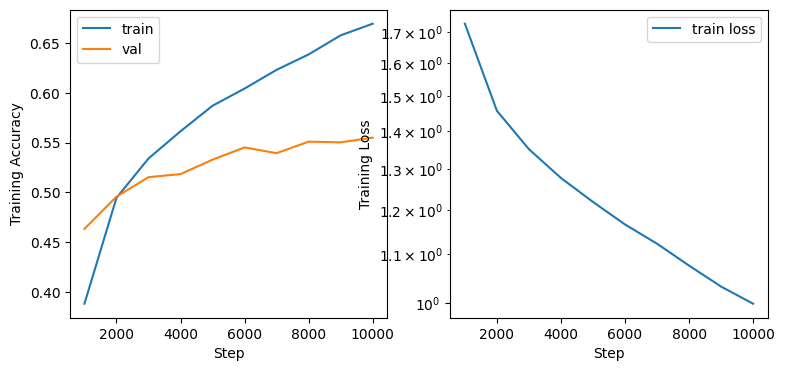

In [54]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# acc
ax = axs[0]
ax.plot(info["step"], info["train_acc"], label="train")
ax.plot(info["step"], info["val_acc"], label="val")
ax.set_ylabel("Training Accuracy")
ax.set_xlabel("Step")
ax.legend()

# loss
ax = axs[1]
ax.plot(info["step"], info["loss"], label="train loss")
ax.set_ylabel("Training Loss")
ax.set_xlabel("Step")
ax.set_yscale("log")
ax.legend()

plt.show()